In [1]:
from distribution_inference.config.core import TrainConfig
from simple_parsing import ArgumentParser
from pathlib import Path
from tqdm import tqdm
import numpy as np
from dataclasses import replace
import os

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.config import DatasetConfig, FairnessEvalConfig
from distribution_inference.utils import flash_utils
from distribution_inference.attacks.blackbox.utils import get_preds

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

09/09/2022 12:13:57:WARNING:The OGB package is out of date. Your version is 1.3.3, while the latest version is 1.3.4.


In [2]:
def to_preds(x):
    exp = np.exp(x)
    return exp / (1 + exp)

In [17]:
fairness_config: FairnessEvalConfig = FairnessEvalConfig.load(
    "configs/new_census/fairness_eval.json",
    drop_extra_fields=False)
# Extract configuration information from config file
train_config: TrainConfig = fairness_config.train_config
model_data_config: DatasetConfig = train_config.data_config

In [18]:
# Without-Shuffle model_config
train_config_wo_shuffle = replace(train_config, misc_config=None)

In [19]:
# Without shuffle model_config, OG raio
train_config_og = replace(train_config_wo_shuffle)
train_config_og.data_config = replace(train_config_og.data_config, value=0.5)

In [6]:
# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper(model_data_config.name)

In [7]:
data_config: DatasetConfig = replace(model_data_config, value=0.5)
ds_baseline = ds_wrapper_class(
    data_config, skip_data=False)

In [8]:
# Check if models are graph-related
are_graph_models = ds_baseline.is_graph_data
if are_graph_models:
    # No concept of 'processed'
    data_ds, (_, test_idx) = ds_baseline.get_loaders(batch_size=fairness_config.batch_size, eval_shuffle=False)
    eval_loader = (data_ds, test_idx)
else:
    _, eval_loader = ds_baseline.get_loaders(batch_size=fairness_config.batch_size, eval_shuffle=False)

In [65]:
labels = [(x[1].numpy(), x[2].numpy()) for x in eval_loader]

In [72]:
labels = np.concatenate(labels, 1)

(2, 20287)

In [74]:
labels

array([[1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [80]:
from scipy.stats import pearsonr
pearsonr(labels[1], 1-labels[0])

(0.15864094983958954, 1.871154507913116e-114)

In [9]:
def get_preds_for_model_config(mc: TrainConfig):
    # Create new DS object for models and data loading
    ds_model = ds_wrapper_class(
        mc.data_config,
        skip_data=True,
        label_noise=train_config.label_noise)

    # Load models
    models = ds_model.get_models(
        mc,
        n_models=fairness_config.num_models,
        on_cpu=fairness_config.on_cpu,
        shuffle=False,
        epochwise_version=mc.save_every_epoch,
        model_arch=mc.model_arch)

    # Get predictions for models
    preds, ground_truth = get_preds(
        eval_loader, models,
        preload=fairness_config.preload,
        multi_class=mc.multi_class)
    
    # Convert to probability values if logits
    if not models[0].is_sklearn_model:
        preds = to_preds(preds)
        
    return preds, ground_truth

In [10]:
def get_preds_for_model_config_adv(mc: TrainConfig):
    # Create new DS object for models and data loading
    data_config_ = replace(mc.data_config, split="adv")
    ds_model = ds_wrapper_class(
        data_config_,
        skip_data=True,
        label_noise=train_config.label_noise)

    # Load models
    models = ds_model.get_models(
        mc,
        n_models=fairness_config.num_models,
        on_cpu=fairness_config.on_cpu,
        shuffle=False,
        epochwise_version=mc.save_every_epoch,
        model_arch=mc.model_arch)

    # Get predictions for models
    preds, ground_truth = get_preds(
        eval_loader, models,
        preload=fairness_config.preload,
        multi_class=mc.multi_class)
    
    # Convert to probability values if logits
    if not models[0].is_sklearn_model:
        preds = to_preds(preds)
        
    return preds, ground_truth

In [20]:
preds_shuffle, gt_shuffle = get_preds_for_model_config(train_config)

Loading models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 242.97it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/shuffle_defense_both/under/0.50/sex/victim/0.8
Available models: 20



Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.79it/s]


In [48]:
train_config_ = replace(train_config)
train_config_.data_config = replace(train_config_.data_config, value=0.1)
preds_shuffle_other, gt_shuffle_other = get_preds_for_model_config(train_config_)

Loading models:   0%|                                                                                                                                                                                                 | 0/20 [00:00<?, ?it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/shuffle_defense_both/under/0.50/sex/victim/0.1
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.64it/s]


In [21]:
preds_noshuffle, gt_no_shuffle = get_preds_for_model_config(train_config_wo_shuffle)

Loading models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 239.46it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/victim/0.8
Available models: 20



Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.68it/s]


In [22]:
preds_og, gt_og = get_preds_for_model_config(train_config_og)

Loading models:  30%|███████████████████████████████████████████████████████▌                                                                                                                                 | 6/20 [00:00<00:00, 48.42it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/victim/0.5
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.70it/s]


In [23]:
preds_adv_5, gt_adv_5 = get_preds_for_model_config_adv(train_config_og)

Loading models:  20%|█████████████████████████████████████                                                                                                                                                    | 4/20 [00:00<00:00, 36.42it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/adv/0.5
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.80it/s]


In [26]:
preds_adv_8, gt_adv_8 = get_preds_for_model_config_adv(train_config_wo_shuffle)

Loading models:  25%|██████████████████████████████████████████████▎                                                                                                                                          | 5/20 [00:00<00:00, 49.39it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/adv/0.8
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.74it/s]


In [27]:
train_config_wo_shuffle.data_config = replace(train_config_wo_shuffle.data_config, value=0.2)
preds_adv_2, gt_adv_2 = get_preds_for_model_config_adv(train_config_wo_shuffle)

Loading models:  20%|█████████████████████████████████████                                                                                                                                                    | 4/20 [00:00<00:00, 38.00it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/adv/0.2
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.75it/s]


In [51]:
train_config_wo_shuffle.data_config = replace(train_config_wo_shuffle.data_config, value=0.1)
preds_adv_1, gt_adv_1 = get_preds_for_model_config_adv(train_config_wo_shuffle)

Loading models:  30%|███████████████████████████████████████████████████████▌                                                                                                                                 | 6/20 [00:00<00:00, 52.15it/s]

Loading models from path /p/adversarialml/as9rw/models_new_census/60_40/mlp2/normal/sex/adv/0.1
Available models: 20


Generating Predictions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.59it/s]


In [24]:
print(preds_shuffle.shape)
print(preds_noshuffle.shape)
print(preds_og.shape)

(20, 20287)
(20, 20287)
(20, 20287)


In [28]:
print(preds_adv_5.shape)
print(preds_adv_2.shape)
print(preds_adv_8.shape)

(20, 20287)
(20, 20287)
(20, 20287)


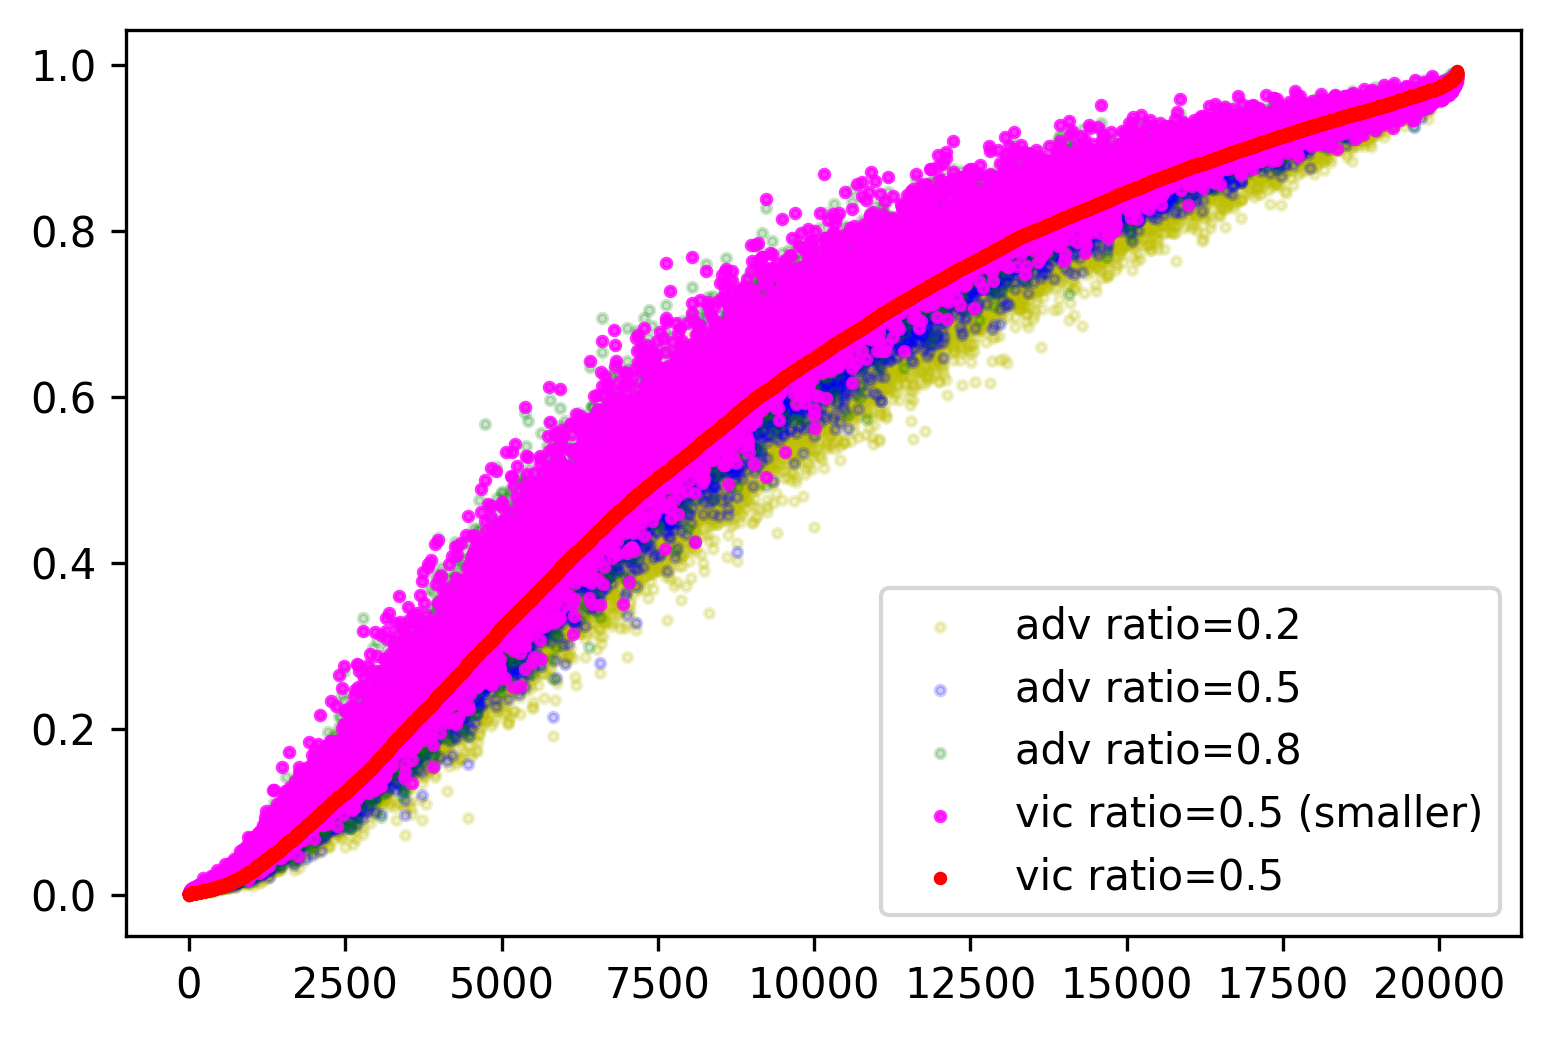

In [44]:
sorted_order = np.argsort(np.mean(preds_og, 0))[:]
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_2, 0)[sorted_order], c='y', s=5, label='adv ratio=0.2', alpha=0.2)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_5, 0)[sorted_order], c='b', s=5, label='adv ratio=0.5', alpha=0.2)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_8, 0)[sorted_order], c='g', s=5, label='adv ratio=0.8', alpha=0.2)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_og, 0)[sorted_order], c='r', s=5, label='vic ratio=0.5')
plt.legend()

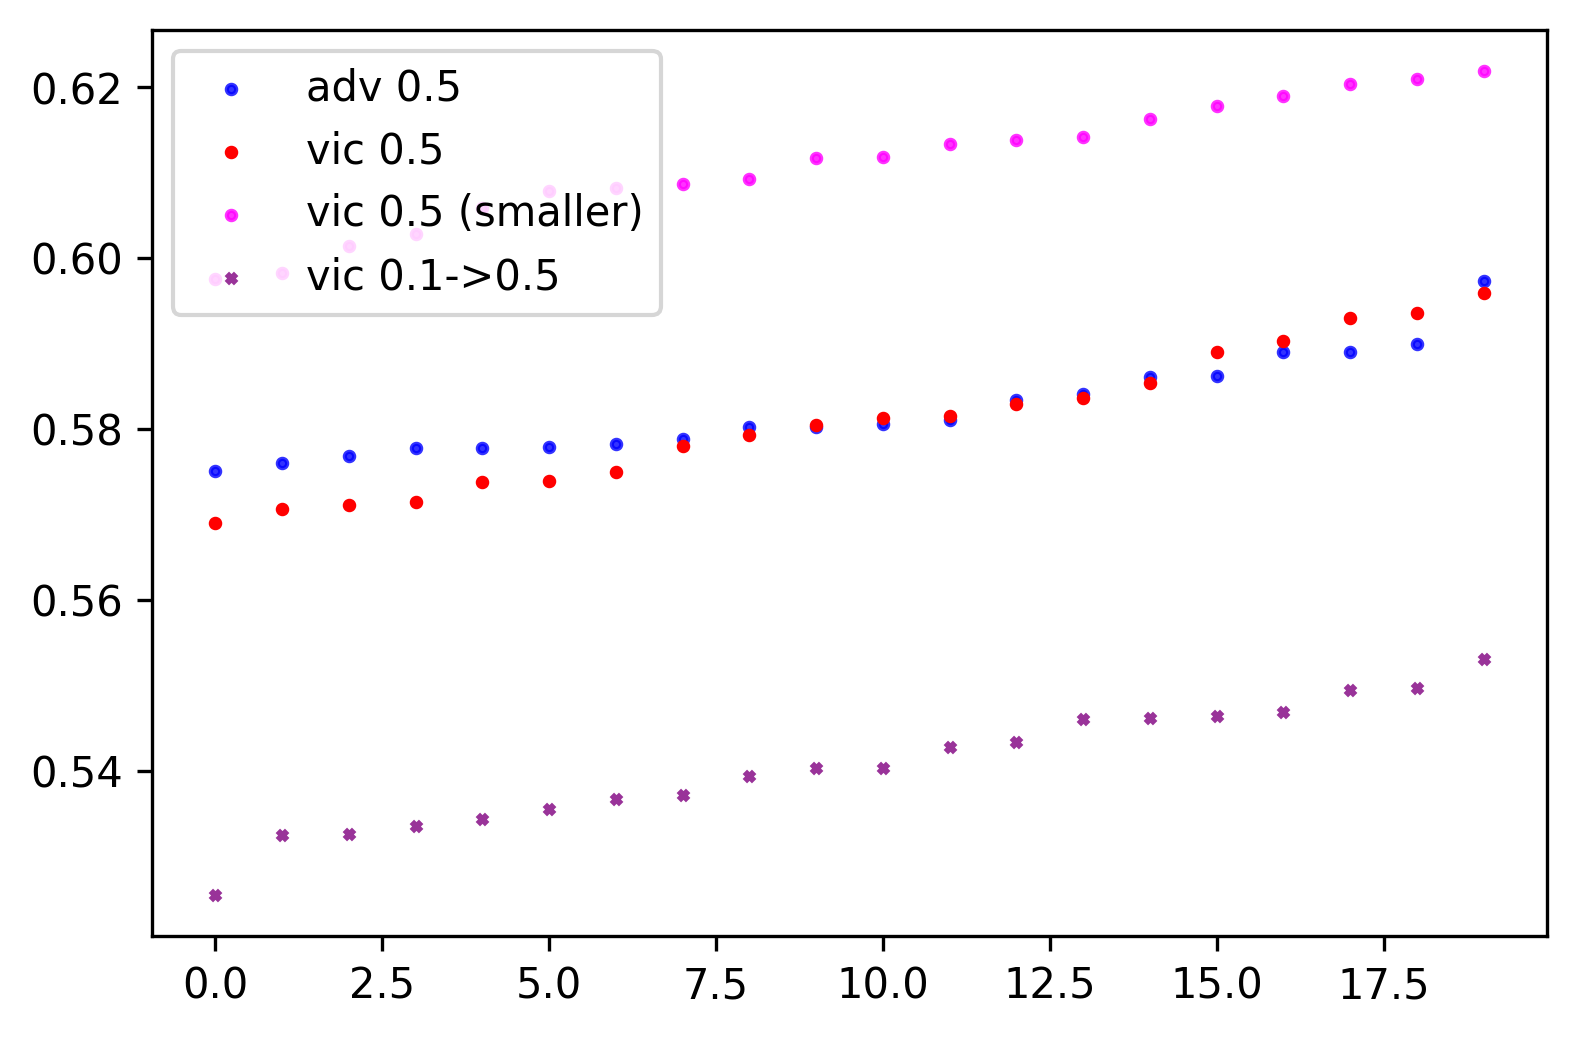

In [83]:
sorted_order = np.argsort(np.mean(preds_og, 1))[:]
# plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_1, 1)[np.argsort(np.mean(preds_adv_1, 1))], c='brown', s=5, label='adv 0.1', alpha=0.8, marker='x')
# plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_2, 1)[np.argsort(np.mean(preds_adv_2, 1))], c='y', s=5, label='adv 0.2', alpha=0.8)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_5, 1)[np.argsort(np.mean(preds_adv_5, 1))], c='b', s=5, label='adv 0.5', alpha=0.8)
# plt.scatter(np.arange(len(sorted_order)), np.mean(preds_adv_8, 1)[np.argsort(np.mean(preds_adv_8, 1))], c='g', s=5, label='adv 0.8', alpha=0.8)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_og, 1)[np.argsort(np.mean(preds_og, 1))], c='r', s=5, label='vic 0.5')
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_shuffle, 1)[np.argsort(np.mean(preds_shuffle, 1))], c='magenta', s=5, label='vic 0.5 (smaller)', alpha=0.8)
plt.scatter(np.arange(len(sorted_order)), np.mean(preds_shuffle_other, 1)[np.argsort(np.mean(preds_shuffle_other, 1))], c='purple', s=5, label='vic 0.1->0.5', alpha=0.8, marker='x')
plt.legend()

In [63]:
preds_adv_1[0]

array([0.96357715, 0.28898224, 0.5152249 , ..., 0.92287654, 0.81089884,
       0.74536145], dtype=float32)

In [ ]:
def KL(x, y):
    small_eps = 1e-4
    x_ = np.clip(x, small_eps, 1 - small_eps)
    y_ = np.clip(y, small_eps, 1 - small_eps)
    x__, y__ = 1 - x_, 1 - y_
    first_term = x_ * (np.log(x_) - np.log(y_))
    second_term = x__ * (np.log(x__) - np.log(y__))
    return np.mean(first_term + second_term, 1)

In [ ]:
# Compute KL divergence values between 0.1 and 0.1->0.5
xx, yy = np.triu_indices(preds_og.shape[0], k=1)
KL_vals = np.array([KL(preds_noshuffle, x,) for x in preds_shuffle])
np.mean(KL_vals)

In [ ]:
# Between 0.5 and 0.1->0.5
KL_vals = np.array([KL(preds_og, x,) for x in preds_shuffle])
np.mean(KL_vals)

In [ ]:
# Between 0.1 and 0.5
KL_vals = np.array([KL(preds_og, x,) for x in preds_noshuffle])
np.mean(KL_vals)

**Looks like models with re-sampling defense are closer to the original ratio, than the ratio they were re-sampled to. Need to get to the bottom of why this is happening**

In [ ]:
# Pick just the first 2 datapoints for now
picked = (2, 7)

In [ ]:
plt.scatter(preds_og[:, picked[0]], preds_og[:, picked[1]], c='r', label='ratio=0.5')
plt.scatter(preds_shuffle[:, picked[0]], preds_shuffle[:, picked[1]], c='g', label='ratio=0.1->0.5')
plt.scatter(preds_noshuffle[:, picked[0]], preds_noshuffle[:, picked[1]], c='b', label='ratio=0.1')
plt.legend()

In [ ]:
og_within_sim = cosine_similarity(preds_og, preds_og)
shuffle_within_sim = cosine_similarity(preds_shuffle, preds_shuffle)
noshuffle_within_sim = cosine_similarity(preds_noshuffle, preds_noshuffle)

og_shuffle_sim = cosine_similarity(preds_og, preds_shuffle)
og_noshuffle_sim = cosine_similarity(preds_og, preds_noshuffle)

shuffle_before_after_sim = cosine_similarity(preds_shuffle, preds_noshuffle)

In [ ]:
np.mean(og_shuffle_sim)

In [ ]:
np.mean(og_noshuffle_sim)

In [ ]:
np.mean(shuffle_before_after_sim)